In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = "train"
test_dir = "test"
categories = ["open eyes", "close eyes"]


In [3]:
def count_images(directory, categories):
    print(f"Checking images in: {directory}")
    for category in categories:
        path = os.path.join(directory, category)
        if not os.path.exists(path):
            print(f"❌ Directory not found: {path}")
            continue
        num_images = len(os.listdir(path))
        print(f"✅ {category}: {num_images} images")

count_images(train_dir, categories)
count_images(test_dir, categories)


Checking images in: train
✅ open eyes: 41295 images
✅ close eyes: 40380 images
Checking images in: test
✅ open eyes: 1657 images
✅ close eyes: 1566 images


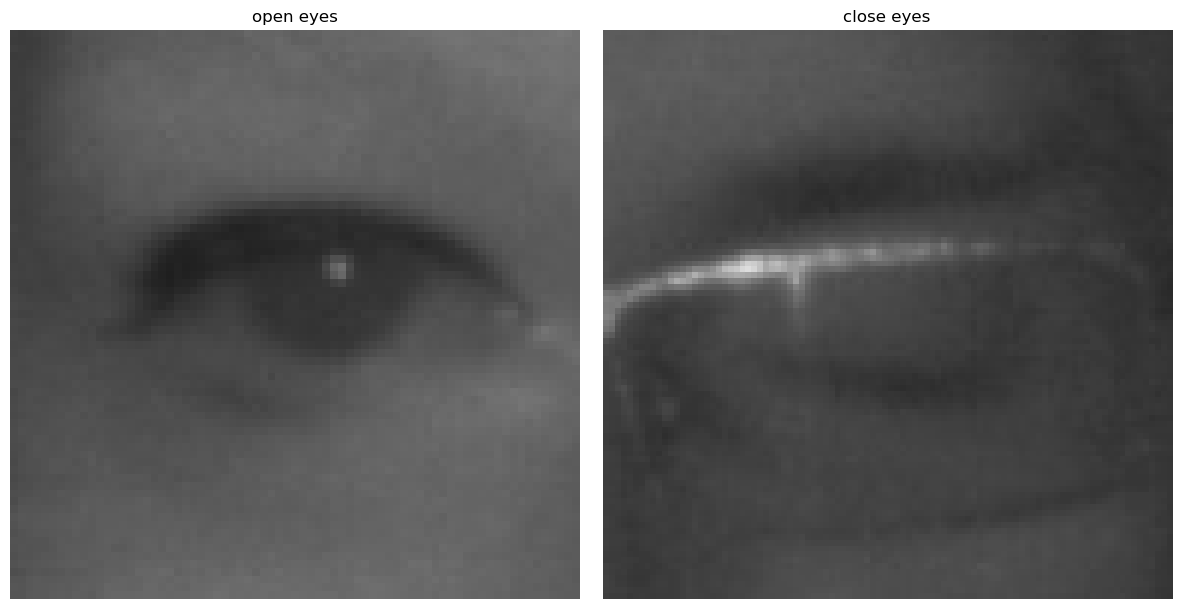

In [4]:
import random

def show_sample_images(directory, categories):
    fig, axes = plt.subplots(1, len(categories), figsize=(12, 6))
    for idx, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        sample_img = random.choice(os.listdir(category_path))
        img_path = os.path.join(category_path, sample_img)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(category)
        axes[idx].axis("off")
    plt.tight_layout()
    plt.show()

show_sample_images(train_dir, categories)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation/test data generator without augmentation:
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)


Found 81675 images belonging to 2 classes.
Found 3223 images belonging to 2 classes.


In [6]:
model = Sequential()

# Convolutional block 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional block 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional block 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # helps prevent overfitting
model.add(Dense(2, activation='softmax'))  # 2 classes: open, closed

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()


C:\Users\HP\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,458 (2.61 MB)

 Trainable params: 683,458 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stop training early if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Save best model during training
checkpoint = ModelCheckpoint(
    filepath='best_drowsiness_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint]
)


C:\Users\HP\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.7913 - loss: 0.4287
Epoch 1: val_accuracy improved from -inf to 0.89389, saving model to best_drowsiness_model.h5


2553/2553 ━━━━━━━━━━━━━━━━━━━━ 1307s 511ms/step - accuracy: 0.7913 - loss: 0.4286 - val_accuracy: 0.8939 - val_loss: 0.2441
Epoch 2/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9228 - loss: 0.2040
Epoch 2: val_accuracy improved from 0.89389 to 0.89482, saving model to best_drowsiness_model.h5


2553/2553 ━━━━━━━━━━━━━━━━━━━━ 346s 136ms/step - accuracy: 0.9228 - loss: 0.2040 - val_accuracy: 0.8948 - val_loss: 0.2430
Epoch 3/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9429 - loss: 0.1559
Epoch 3: val_accuracy improved from 0.89482 to 0.90692, saving model to best_drowsiness_model.h5


2553/2553 ━━━━━━━━━━━━━━━━━━━━ 341s 133ms/step - accuracy: 0.9429 - loss: 0.1559 - val_accuracy: 0.9069 - val_loss: 0.2271
Epoch 4/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9553 - loss: 0.1292
Epoch 4: val_accuracy improved from 0.90692 to 0.91281, saving model to best_drowsiness_model.h5


2553/2553 ━━━━━━━━━━━━━━━━━━━━ 372s 146ms/step - accuracy: 0.9553 - loss: 0.1292 - val_accuracy: 0.9128 - val_loss: 0.2159
Epoch 5/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9622 - loss: 0.1068
Epoch 5: val_accuracy did not improve from 0.91281
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 338s 132ms/step - accuracy: 0.9622 - loss: 0.1068 - val_accuracy: 0.8653 - val_loss: 0.3679
Epoch 6/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9670 - loss: 0.0953
Epoch 6: val_accuracy improved from 0.91281 to 0.93050, saving model to best_drowsiness_model.h5


2553/2553 ━━━━━━━━━━━━━━━━━━━━ 840s 329ms/step - accuracy: 0.9670 - loss: 0.0953 - val_accuracy: 0.9305 - val_loss: 0.1785
Epoch 7/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.9697 - loss: 0.0866
Epoch 7: val_accuracy did not improve from 0.93050
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 2312s 906ms/step - accuracy: 0.9697 - loss: 0.0866 - val_accuracy: 0.9125 - val_loss: 0.2308
Epoch 8/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9717 - loss: 0.0803
Epoch 8: val_accuracy did not improve from 0.93050
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 924s 362ms/step - accuracy: 0.9717 - loss: 0.0803 - val_accuracy: 0.9196 - val_loss: 0.2166
Epoch 9/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9720 - loss: 0.0762
Epoch 9: val_accuracy did not improve from 0.93050
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 310s 122ms/step - accuracy: 0.9720 - loss: 0.0762 - val_accuracy: 0.9240 - val_loss: 0.1992
Epoch 10/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9747 - loss: 

2553/2553 ━━━━━━━━━━━━━━━━━━━━ 313s 123ms/step - accuracy: 0.9747 - loss: 0.0714 - val_accuracy: 0.9317 - val_loss: 0.1723
Epoch 11/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9762 - loss: 0.0670
Epoch 11: val_accuracy did not improve from 0.93174
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 308s 121ms/step - accuracy: 0.9762 - loss: 0.0670 - val_accuracy: 0.9203 - val_loss: 0.2414
Epoch 12/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9773 - loss: 0.0658
Epoch 12: val_accuracy did not improve from 0.93174
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 304s 119ms/step - accuracy: 0.9773 - loss: 0.0658 - val_accuracy: 0.9200 - val_loss: 0.2177
Epoch 13/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9779 - loss: 0.0630
Epoch 13: val_accuracy did not improve from 0.93174
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 303s 119ms/step - accuracy: 0.9779 - loss: 0.0630 - val_accuracy: 0.9258 - val_loss: 0.2081
Epoch 14/15
2553/2553 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9789 - l

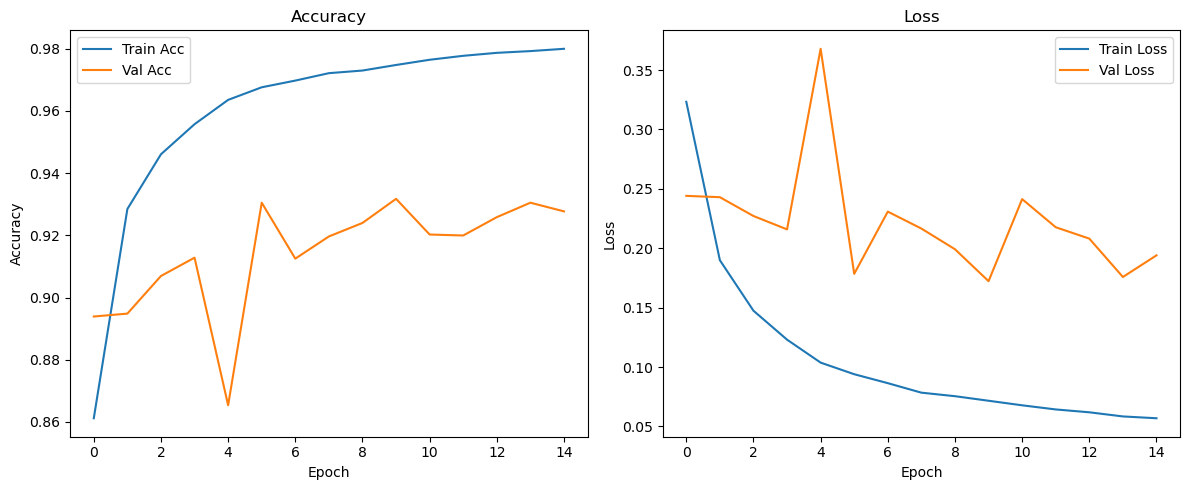

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
from tensorflow.keras.models import load_model

best_model = load_model("best_drowsiness_model.h5")
test_loss, test_acc = best_model.evaluate(validation_generator)
print(f"✅ Final Test Accuracy: {test_acc*100:.2f}%")


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9330 - loss: 0.1639
✅ Final Test Accuracy: 93.17%


In [10]:
model.save("drowsiness_model.h5")
print("✅ Drowsiness model saved as 'drowsiness_model.h5'")


✅ Drowsiness model saved as 'drowsiness_model.h5'
